In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import jax
Array = jax.Array
import jax.numpy as jnp
import jax.scipy as jsp
from jax.scipy import optimize
import scipy.stats
import dataclasses
from functools import partial
from typing import Callable, Union

from ott.geometry import geometry, pointcloud
from ott.solvers import linear

import jaxopt

from VP_solver.jax_vp_solver import Mesh, make_mesh, VlasovPoissonSolver

matplotlib.rcParams.update({
    'font.size': 14,  # General font size
    'axes.labelsize': 14,  # Axis label size
    'axes.titlesize': 14,  # Title size
    'xtick.labelsize': 14,  # X-tick label size
    'ytick.labelsize': 14,  # Y-tick label size
    'legend.fontsize': 14   # Legend font size
})

print(jax.devices())

[CudaDevice(id=0)]


In [2]:
# Problem setup
nx = 512
nv = 512
dt = 0.1
t_final = 30  # Adjusted for demonstration purposes
L = 10 * jnp.pi
LV = 6.0
#hv = 0.1  # Example value for velocity step (modify as per your setup)
#hx = 0.1  # Example value for space step (modify as per your setup)

In [3]:
mesh = make_mesh(L, LV, nx, nv)

alpha = 0.5
mu1 = 2.4
mu2 = -2.4
f_eq = (alpha * jnp.exp(-0.5 * (mesh.V - mu1)**2) + (1 - alpha) * jnp.exp(-0.5 * (mesh.V - mu2)**2)) / jnp.sqrt(2 * jnp.pi)
epsilon = 0.001
k_0 = 0.2
f_iv = (1.0 + epsilon * jnp.cos(k_0 * mesh.X)) * f_eq

# External field parameters (coefficients for the cosine terms)
#a_k = [0.004, 0.05, -0.02, 0.0, 0.0]
k_total = 14
a_k = jax.random.uniform(jax.random.key(888), (k_total,), minval=-1.0, maxval=1.0)

# Function to compute the external field H (not time-dependent)
def compute_external_field(xs, a_k):
    H = jnp.zeros_like(xs)  # Initialize H as a 1D array (space)
    for k in range(1, len(a_k)+1):  # Iterate over k from 1 to 15
        H += a_k[k - 1] * jnp.cos(k * xs / L * 2 * jnp.pi)  # Compute H for each k and sum
    return H

# Compute the external field
H = compute_external_field(mesh.xs, a_k)

num_steps = int(t_final / dt)

# Function to plot the distribution of f_eq over x and v
def plot_feq_distribution(ax, f_eq, title):
    im = ax.imshow(f_eq.transpose(), extent=[mesh.xs[0], mesh.xs[-1], mesh.vs[0], mesh.vs[-1]], aspect='auto', cmap='viridis')  # 'auto' aspect ratio
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('v')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Adjusted colorbar size

# Modify the plot_distribution function to handle 2D data
def plot_distribution(ax, data, title, time):
    im = ax.imshow(data.T, extent=[mesh.xs[0], mesh.xs[-1], mesh.vs[0], mesh.vs[-1]], aspect='auto', cmap='viridis')  # Transpose data
    ax.set_title(f'{title} (t={time:.2f})')
    ax.set_xlabel('x')
    ax.set_ylabel('v')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Adjusted colorbar size

solver = VlasovPoissonSolver(mesh=mesh, dt=dt, f_eq=jnp.array(f_eq))

# JIT-compiled forward solver
solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))

# Fix the unpacking here
f_array, E_array, ee_array = solver_jit(jnp.array(f_iv), jnp.array(H), t_final=t_final)

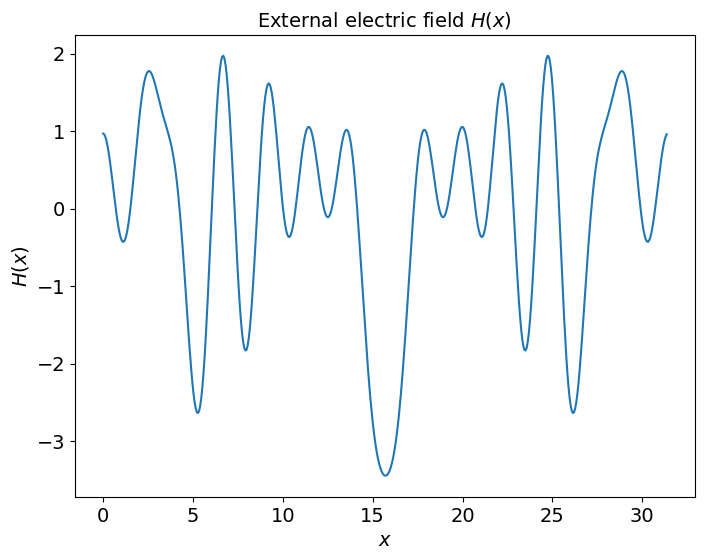

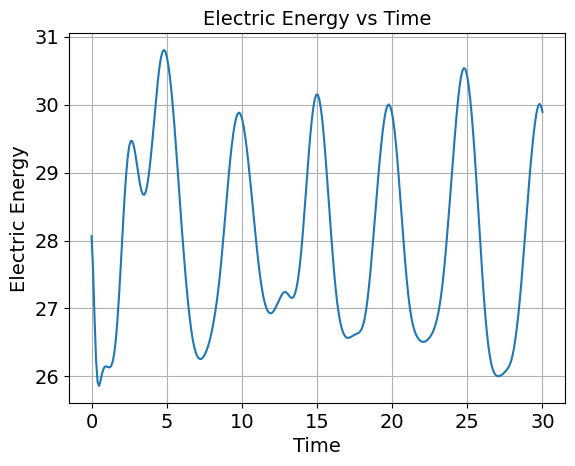

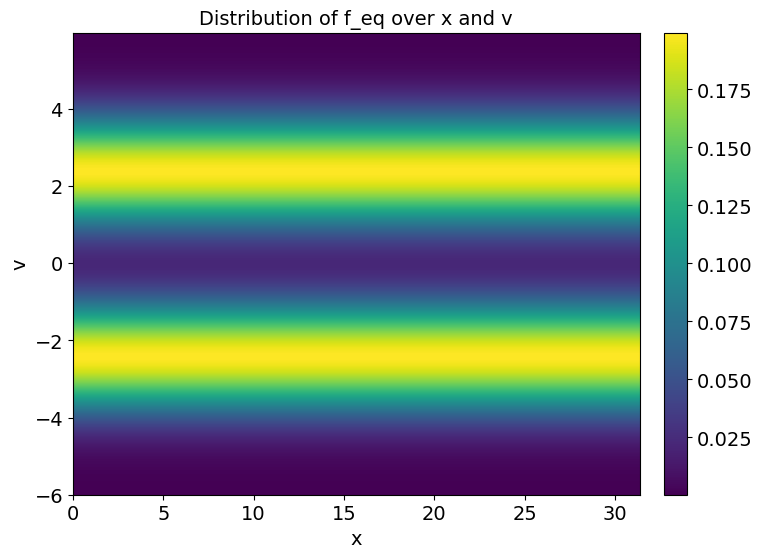

(512, 512)


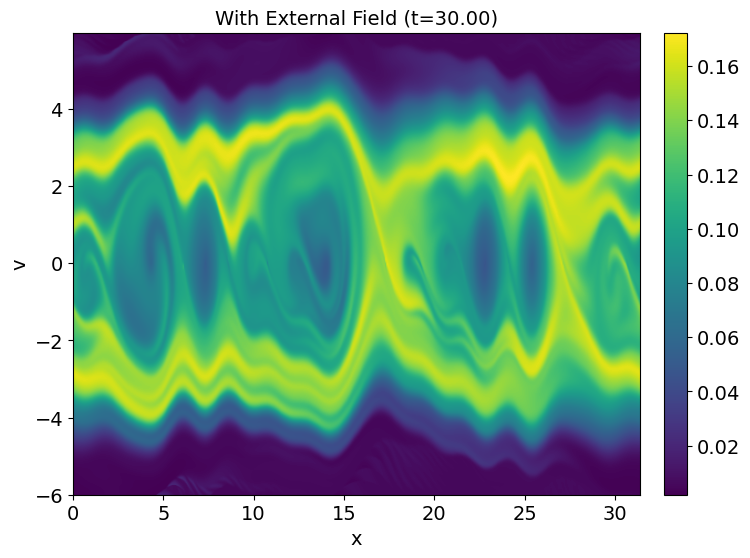

In [4]:
# Create a figure with a single plot for electric energy
fig, ax = plt.subplots(figsize=(8, 6))
t_values = jnp.linspace(0, t_final, int(t_final / dt))


plt.plot(mesh.xs, H)
plt.xlabel('$x$')
plt.ylabel('$H(x)$')
plt.title('External electric field $H(x)$')
plt.show()

plt.plot(t_values, ee_array)
plt.xlabel('Time')
plt.ylabel('Electric Energy')
plt.title('Electric Energy vs Time')
plt.grid(True)
plt.show()

# Create a figure with a single plot for f_eq
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the distribution of f_eq over x and v
plot_feq_distribution(ax, f_eq, 'Distribution of f_eq over x and v')

# Display the plot
plt.show()

print(f_array.shape)  # This will help understand the dimensions of f_array


# Create a figure with a single plot
fig, ax = plt.subplots(figsize=(8, 6))

# f_array is already a 2D array, so pass it directly to the plot
plot_distribution(ax, f_array, 'With External Field', t_final)

# Display the plot
plt.show()

In [5]:
# Optimization through auto-differentiation with fixed basis.

# Function to compute the external field H based on coefficients a_k
def compute_external_field(xs, a_k):
    H = jnp.zeros_like(xs)
    for k in range(1, len(a_k)+1):  # k from 1 to 15
        H += a_k[k-1] * jnp.cos(k * xs / L * 2 * jnp.pi)
    return H

# Adjust the J function to use f_final
def J(f_final, f_eq, solver):
    return jnp.sum((f_final - f_eq) ** 2) * solver.mesh.dx * solver.mesh.dv

# Define the cost function using JAX
def cost_function(a_k):
    H = compute_external_field(mesh.xs, a_k)
    # JIT-compiled forward solver
    solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))
    f_array, E_array, ee_array = solver_jit(jnp.array(f_iv), jnp.array(H), t_final)
    f_final = f_array
    cost = J(f_final, f_eq, solver)
    return cost


maxiter = 200
solver_opt = jaxopt.LBFGS(fun=cost_function, maxiter=maxiter)


# Define a scan function to iterate with `jax.lax.scan`
def scan_fn(carry, _):
    x, state = carry
    x, state = solver_opt.update(x, state)
    obj_value = cost_function(x)
    return (x, state), obj_value

# Initial point and state
# External field parameters (coefficients for the cosine terms)
# Initial guess for the coefficients
k_total = 14
#a_k = jnp.array([0.0, 0.0, -0.0, 0.0, 0.0,  -0.0,
#  0.0,    0.0,  -0.0, -0.0, -0.0,  0.0,
# -0.0, 0])
ak_init = jax.random.uniform(jax.random.key(888), (k_total,), minval=-1.0, maxval=1.0)
init_state = solver_opt.init_state(ak_init)

# Run the optimization and collect objective values using `scan`
res_opt_l2, objective_values_l2 = jax.lax.scan(scan_fn, (ak_init, init_state), None, length=solver_opt.maxiter)



ak_opt_l2, state = res_opt_l2

"""
# Compute the gradient using JAX's automatic differentiation
cost_and_grad_function = jax.jit(jax.value_and_grad(cost_function))

# JIT-compiled forward solver
solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))

# Plot the final distribution before optimization using the initial guess of H
H_initial = compute_external_field(mesh.xs, a_k)
f_array_initial, E_array_initial, ee_array_initial = solver_jit(jnp.array(f_iv), jnp.array(H_initial), t_final)

f_final_initial = f_array_initial

# Print J (cost function value) for the initial guess
J_initial = J(f_final_initial, f_eq, solver)
print(f'Initial cost J: {J_initial}')

# Create a figure for the initial plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the distribution at the final time with the initial guess
plot_distribution(ax, f_array_initial, 'Initial Guess With External Field', t_final)

# Display the initial plot
plt.show()

# Now proceed with the optimization loop
maxIter = 400  # Number of optimization iterations
hist_J = []

for i in range(maxIter):
    # Compute cost and gradient
    cost, grad = cost_and_grad_function(a_k)
    hist_J.append(cost)
    if i%10 == 0:
        print(f'Iteration {i}, Cost: {cost}')
        #print(f'Iteration {i}, a_k: {a_k}')  # Print the current value of a_k

    # Update a_k using a simple gradient descent step or line search
    # For simplicity, let's use gradient descent with a fixed learning rate
    learning_rate = 0.1
    a_k = a_k - learning_rate * grad
    
    # After each iteration, plot the distribution
    H = compute_external_field(mesh.xs, a_k)
    ff_array, E_array, ee_array = solver.run_forward_jax_scan(jnp.array(f_iv), jnp.array(H), t_final)
    
    f_final = ff_array
"""
# Plot the value of the cost function during the iteration process
#plt.plot(hist_J)
#plt.title('Convergence in time')
#plt.ylabel('J(H)')
#plt.xlabel('Iterations')
#plt.show()

# Plot the distribution at the final time for the current iteration
#fig, ax = plt.subplots(figsize=(8, 6))
#plot_distribution(ax, f_final, 'With External Field', t_final)
#plt.show()

2024-11-04 01:18:40.383549: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3020] Can't reduce memory use below 10.09GiB (10830474783 bytes) by rematerialization; only reduced to 10.29GiB (11045369608 bytes), down from 10.29GiB (11046422352 bytes) originally


"\n# Compute the gradient using JAX's automatic differentiation\ncost_and_grad_function = jax.jit(jax.value_and_grad(cost_function))\n\n# JIT-compiled forward solver\nsolver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))\n\n# Plot the final distribution before optimization using the initial guess of H\nH_initial = compute_external_field(mesh.xs, a_k)\nf_array_initial, E_array_initial, ee_array_initial = solver_jit(jnp.array(f_iv), jnp.array(H_initial), t_final)\n\nf_final_initial = f_array_initial\n\n# Print J (cost function value) for the initial guess\nJ_initial = J(f_final_initial, f_eq, solver)\nprint(f'Initial cost J: {J_initial}')\n\n# Create a figure for the initial plot\nfig, ax = plt.subplots(figsize=(8, 6))\n\n# Plot the distribution at the final time with the initial guess\nplot_distribution(ax, f_array_initial, 'Initial Guess With External Field', t_final)\n\n# Display the initial plot\nplt.show()\n\n# Now proceed with the optimization loop\nmaxIte

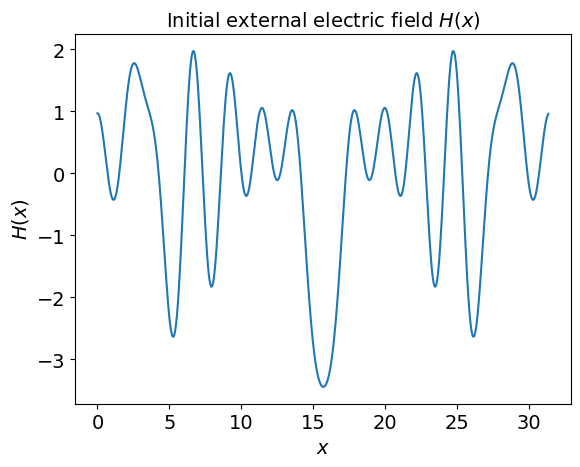

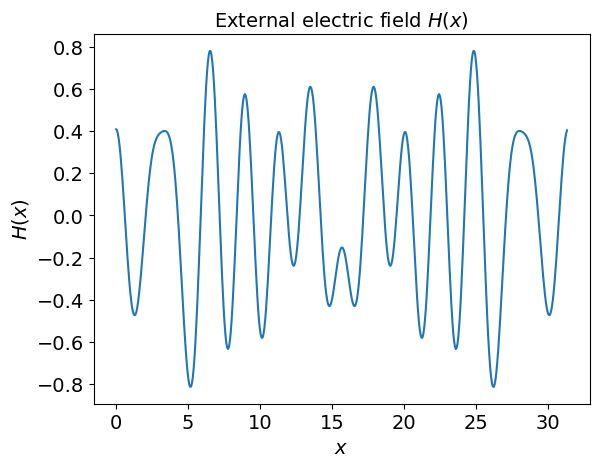

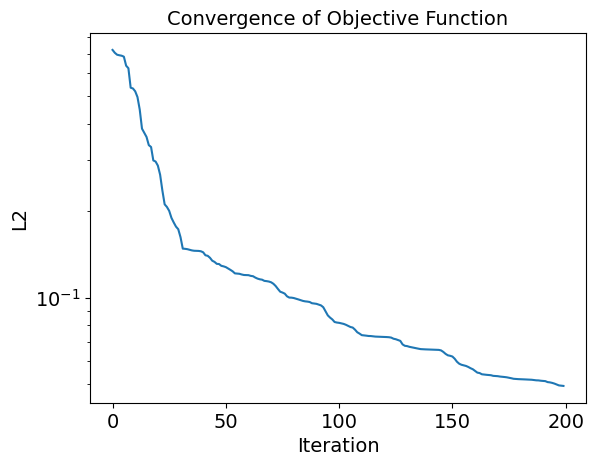

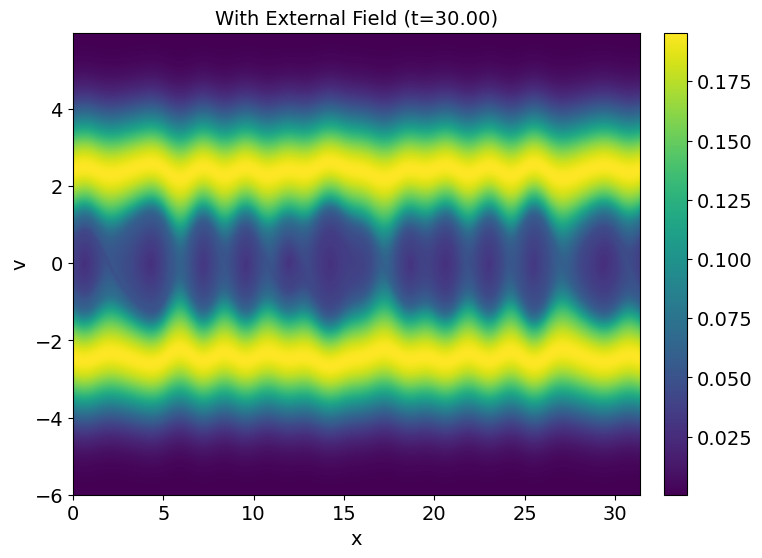

In [10]:
H_init = compute_external_field(mesh.xs, ak_init)
H = compute_external_field(mesh.xs, ak_opt_l2)
ff_array, E_array, ee_array = solver.run_forward_jax_scan(jnp.array(f_iv), jnp.array(H), t_final)
    
f_final = ff_array

plt.plot(mesh.xs, H_init)
plt.xlabel('$x$')
plt.ylabel('$H(x)$')
plt.title('Initial external electric field $H(x)$')
plt.show()

plt.plot(mesh.xs, H)
plt.xlabel('$x$')
plt.ylabel('$H(x)$')
plt.title('External electric field $H(x)$')
plt.show()

# Plot the convergence
objective_values_l2 = jax.device_get(objective_values_l2)  # Move from device to host
plt.plot(objective_values_l2)
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("L2")
plt.title("Convergence of Objective Function")
plt.show()

# Plot the distribution at the final time for the current iteration
fig, ax = plt.subplots(figsize=(8, 6))
plot_distribution(ax, f_final, 'With External Field', t_final)
plt.show()

In [11]:
# Optimization through auto-differentiation with fixed basis.

# External field parameters (coefficients for the cosine terms)
# Initial guess for the coefficients
k_total = 14
#a_k = jnp.array([0.0, 0.0, -0.0, 0.0, 0.0,  -0.0,
#  0.0,    0.0,  -0.0, -0.0, -0.0,  0.0,
# -0.0, 0])
a_k = jax.random.uniform(jax.random.key(888), (k_total,), minval=-1.0, maxval=1.0)

# Function to compute the external field H based on coefficients a_k
def compute_external_field(xs, a_k):
    H = jnp.zeros_like(xs)
    for k in range(1, 15):  # k from 1 to 11
        H += a_k[k-1] * jnp.cos(k * xs / L * 2 * jnp.pi)
    return H

def kl_divergence(f_final, f_eq, solver, eps=1e-8):
    # Normalize the distributions so they sum to 1
    f_final = f_final / (jnp.sum(f_final) * solver.mesh.dx * solver.mesh.dv + eps)
    f_eq = f_eq / (jnp.sum(f_eq) * solver.mesh.dx * solver.mesh.dv + eps)
    
    # Compute KL divergence, adding eps to avoid log(0)
    kl_div = jnp.sum(f_final * jnp.log(f_final / (f_eq + eps) + eps)) * solver.mesh.dx * solver.mesh.dv
    return kl_div

def cost_function_kl(a_k):
    H = compute_external_field(mesh.xs, a_k)
    # JIT-compiled forward solver
    solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))
    f_array, E_array, ee_array = solver_jit(jnp.array(f_iv), jnp.array(H), t_final)
    f_final = f_array
    cost = kl_divergence(f_final, f_eq, solver)
    return cost

maxiter = 200
solver_opt = jaxopt.LBFGS(fun=cost_function_kl, maxiter=maxiter)

# Define a scan function to iterate with `jax.lax.scan`
def scan_fn(carry, _):
    x, state = carry
    x, state = solver_opt.update(x, state)
    obj_value = cost_function(x)
    return (x, state), obj_value

# Initial point and state
# External field parameters (coefficients for the cosine terms)
# Initial guess for the coefficients
k_total = 14
#a_k = jnp.array([0.0, 0.0, -0.0, 0.0, 0.0,  -0.0,
#  0.0,    0.0,  -0.0, -0.0, -0.0,  0.0,
# -0.0, 0])
a_k_init = jax.random.uniform(jax.random.key(888), (k_total,), minval=-1.0, maxval=1.0)
init_state = solver_opt.init_state(a_k_init)

# Run the optimization and collect objective values using `scan`
res_opt_kl, objective_values_kl = jax.lax.scan(scan_fn, (a_k_init, init_state), None, length=solver_opt.maxiter)


ak_opt_kl, state = res_opt_kl


"""
# Compute the gradient using JAX's automatic differentiation
cost_and_grad_function = jax.jit(jax.value_and_grad(cost_function_kl))

# JIT-compiled forward solver
solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))

# Plot the final distribution before optimization using the initial guess of H
H_initial = compute_external_field(mesh.xs, a_k)
f_array_initial, E_array_initial, ee_array_initial = solver_jit(jnp.array(f_iv), jnp.array(H_initial), t_final)

f_final_initial = f_array_initial

# Print J (cost function value) for the initial guess
J_initial = kl_divergence(f_final_initial, f_eq, solver)
print(f'Initial cost J: {J_initial}')

# Create a figure for the initial plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the distribution at the final time with the initial guess
plot_distribution(ax, f_array_initial, 'Initial Guess With External Field', t_final)

# Display the initial plot
plt.show()

# Now proceed with the optimization loop
maxIter = 400  # Number of optimization iterations
hist_J = []

for i in range(maxIter):
    # Compute cost and gradient
    cost, grad = cost_and_grad_function(a_k)
    hist_J.append(cost)
    if i%10 == 0:
        print(f'Iteration {i}, Cost: {cost}')
        #print(f'Iteration {i}, a_k: {a_k}')  # Print the current value of a_k
    
    # Update a_k using a simple gradient descent step or line search
    # For simplicity, let's use gradient descent with a fixed learning rate
    learning_rate = 0.1
    a_k = a_k - learning_rate * grad
    
    # After each iteration, plot the distribution
    H = compute_external_field(mesh.xs, a_k)
    ff_array, E_array, ee_array = solver.run_forward_jax_scan(jnp.array(f_iv), jnp.array(H), t_final)
    
    f_final = ff_array

# Plot the value of the cost function during the iteration process
plt.plot(hist_J)
plt.title('Convergence in time')
plt.ylabel('J(H)')
plt.xlabel('Iterations')
plt.show()

# Plot the distribution at the final time for the current iteration
fig, ax = plt.subplots(figsize=(8, 6))
plot_distribution(ax, f_final, 'With External Field', t_final)
plt.show()
"""

"\n# Compute the gradient using JAX's automatic differentiation\ncost_and_grad_function = jax.jit(jax.value_and_grad(cost_function_kl))\n\n# JIT-compiled forward solver\nsolver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))\n\n# Plot the final distribution before optimization using the initial guess of H\nH_initial = compute_external_field(mesh.xs, a_k)\nf_array_initial, E_array_initial, ee_array_initial = solver_jit(jnp.array(f_iv), jnp.array(H_initial), t_final)\n\nf_final_initial = f_array_initial\n\n# Print J (cost function value) for the initial guess\nJ_initial = kl_divergence(f_final_initial, f_eq, solver)\nprint(f'Initial cost J: {J_initial}')\n\n# Create a figure for the initial plot\nfig, ax = plt.subplots(figsize=(8, 6))\n\n# Plot the distribution at the final time with the initial guess\nplot_distribution(ax, f_array_initial, 'Initial Guess With External Field', t_final)\n\n# Display the initial plot\nplt.show()\n\n# Now proceed with the optimizati

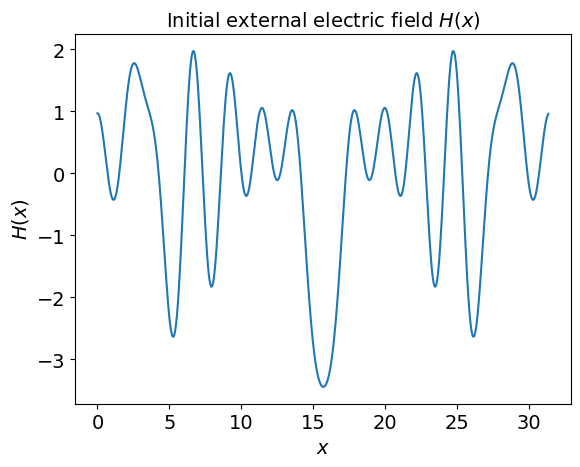

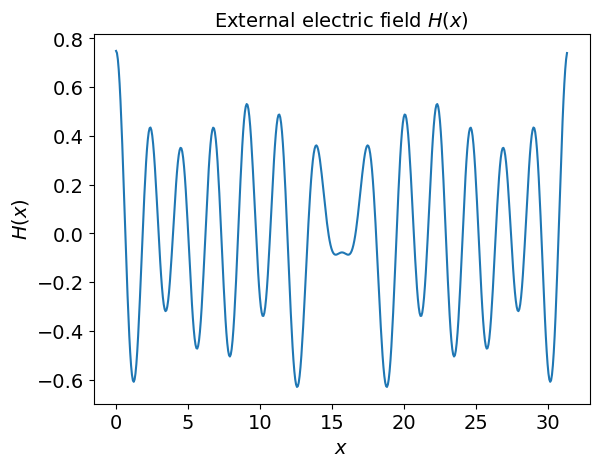

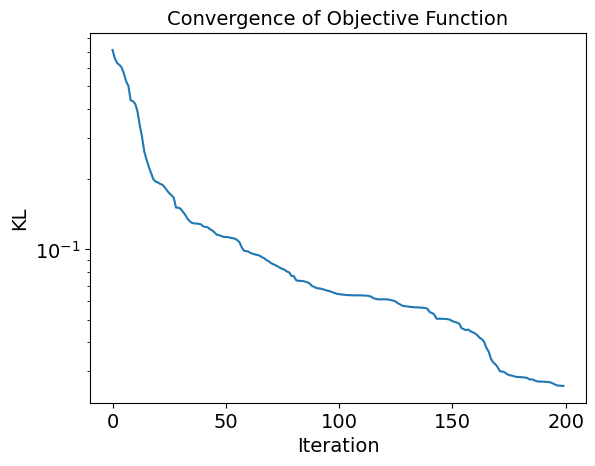

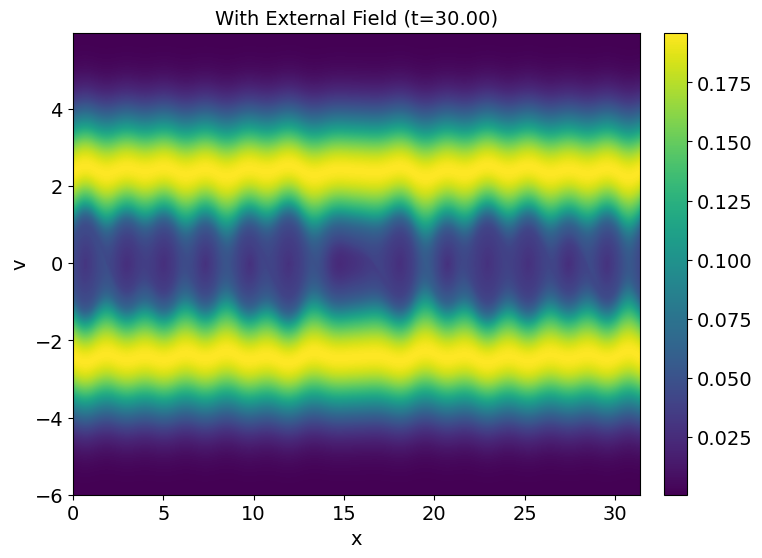

In [12]:
H_init = compute_external_field(mesh.xs, ak_init)
H = compute_external_field(mesh.xs, ak_opt_kl)
ff_array, E_array, ee_array = solver.run_forward_jax_scan(jnp.array(f_iv), jnp.array(H), t_final)
    
f_final = ff_array


plt.plot(mesh.xs, H_init)
plt.xlabel('$x$')
plt.ylabel('$H(x)$')
plt.title('Initial external electric field $H(x)$')
plt.show()

plt.plot(mesh.xs, H)
plt.xlabel('$x$')
plt.ylabel('$H(x)$')
plt.title('External electric field $H(x)$')
plt.show()

# Plot the convergence
objective_values_kl = jax.device_get(objective_values_kl)  # Move from device to host
plt.plot(objective_values_kl)
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("KL")
plt.title("Convergence of Objective Function")
plt.show()

# Plot the distribution at the final time for the current iteration
fig, ax = plt.subplots(figsize=(8, 6))
plot_distribution(ax, f_final, 'With External Field', t_final)
plt.show()

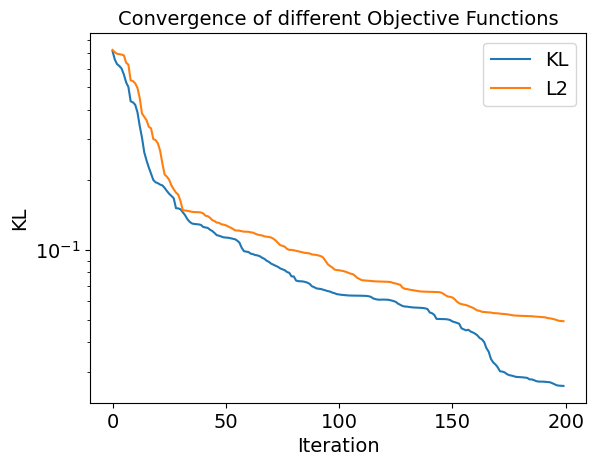

In [14]:
plt.plot(objective_values_kl, label='KL')
plt.plot(objective_values_l2, label='L2')
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("KL")
plt.title("Convergence of different Objective Functions")
plt.legend()
plt.show()

In [10]:
# Optimization through auto-differentiation with fixed basis.

# External field parameters (coefficients for the cosine terms)
# Initial guess for the coefficients
k_total = 14
#a_k = jnp.array([0.0, 0.0, -0.0, 0.0, 0.0,  -0.0,
#  0.0,    0.0,  -0.0, -0.0, -0.0,  0.0,
# -0.0, 0])
a_k = jax.random.uniform(jax.random.key(888), (k_total,), minval=-1.0, maxval=1.0)

# Function to compute the external field H based on coefficients a_k
def compute_external_field(xs, a_k):
    H = jnp.zeros_like(xs)
    for k in range(1, 15):  # k from 1 to 11
        H += a_k[k-1] * jnp.cos(k * xs / L * 2 * jnp.pi)
    return H


# Adjust the J function to use f_final
def Wasserstein(f_final, f_eq, solver):
    x_v = jnp.stack([solver.mesh.xs,solver.mesh.vs],axis=1)
    f_eq_marginal = f_eq[0]/jnp.sum(f_eq[0])
    f_final_marginal = f_final[0]/jnp.sum(f_final[0])
    geom = pointcloud.PointCloud(x_v)
    ot = linear.solve(geom, a=f_final_marginal , b=f_eq_marginal)
    return ot.reg_ot_cost

# Define the cost function using JAX
def cost_function_wass(a_k):
    H = compute_external_field(mesh.xs, a_k)
    # JIT-compiled forward solver
    solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))
    f_array, E_array, ee_array = solver_jit(jnp.array(f_iv), jnp.array(H), t_final)
    f_final = f_array
    cost = Wasserstein(f_final, f_eq, solver)
    return cost



maxiter = 200
solver_opt = jaxopt.LBFGS(fun=cost_function_wass, maxiter=maxiter)

res_opt_wass = solver_opt.run(a_k_init)

ak_opt_wass, state_wass = res_opt_wass

"""
# Compute the gradient using JAX's automatic differentiation
cost_and_grad_function = jax.jit(jax.value_and_grad(cost_function))


# JIT-compiled forward solver
solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))

# Plot the final distribution before optimization using the initial guess of H
H_initial = compute_external_field(mesh.xs, a_k)
f_array_initial, E_array_initial, ee_array_initial = solver_jit(jnp.array(f_iv), jnp.array(H_initial), t_final)

f_final_initial = f_array_initial

# Print J (cost function value) for the initial guess
J_initial = Wasserstein(f_final_initial, f_eq, solver)
print(f'Initial cost J: {J_initial}')

# Create a figure for the initial plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the distribution at the final time with the initial guess
plot_distribution(ax, f_array_initial, 'Initial Guess With External Field', t_final)

# Display the initial plot
plt.show()

# Now proceed with the optimization loop
maxIter = 400  # Number of optimization iterations
hist_J = []

for i in range(maxIter):
    # Compute cost and gradient
    cost, grad = cost_and_grad_function(a_k)
    hist_J.append(cost)
    if i%10 == 0:
        print(f'Iteration {i}, Cost: {cost}')
        #print(f'Iteration {i}, a_k: {a_k}')  # Print the current value of a_k
    
    # Update a_k using a simple gradient descent step or line search
    # For simplicity, let's use gradient descent with a fixed learning rate
    learning_rate = 0.1
    a_k = a_k - learning_rate * grad
    
    # After each iteration, plot the distribution
    H = compute_external_field(mesh.xs, a_k)
    ff_array, E_array, ee_array = solver.run_forward_jax_scan(jnp.array(f_iv), jnp.array(H), t_final)
    
    f_final = ff_array

# Plot the value of the cost function during the iteration process
plt.plot(hist_J)
plt.title('Convergence in time')
plt.ylabel('J(H)')
plt.xlabel('Iterations')
plt.show()

# Plot the distribution at the final time for the current iteration
fig, ax = plt.subplots(figsize=(8, 6))
plot_distribution(ax, f_final, 'With External Field', t_final)
plt.show()
"""

"\n# Compute the gradient using JAX's automatic differentiation\ncost_and_grad_function = jax.jit(jax.value_and_grad(cost_function))\n\n\n# JIT-compiled forward solver\nsolver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))\n\n# Plot the final distribution before optimization using the initial guess of H\nH_initial = compute_external_field(mesh.xs, a_k)\nf_array_initial, E_array_initial, ee_array_initial = solver_jit(jnp.array(f_iv), jnp.array(H_initial), t_final)\n\nf_final_initial = f_array_initial\n\n# Print J (cost function value) for the initial guess\nJ_initial = Wasserstein(f_final_initial, f_eq, solver)\nprint(f'Initial cost J: {J_initial}')\n\n# Create a figure for the initial plot\nfig, ax = plt.subplots(figsize=(8, 6))\n\n# Plot the distribution at the final time with the initial guess\nplot_distribution(ax, f_array_initial, 'Initial Guess With External Field', t_final)\n\n# Display the initial plot\nplt.show()\n\n# Now proceed with the optimization 

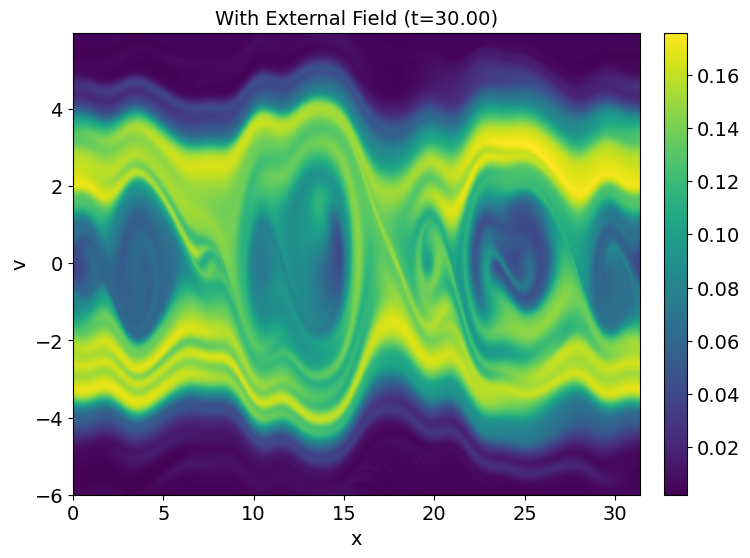

In [11]:
H = compute_external_field(mesh.xs, ak_opt_wass)
ff_array, E_array, ee_array = solver.run_forward_jax_scan(jnp.array(f_iv), jnp.array(H), t_final)
    
f_final = ff_array

# Plot the distribution at the final time for the current iteration
fig, ax = plt.subplots(figsize=(8, 6))
plot_distribution(ax, f_final, 'With External Field', t_final)
plt.show()

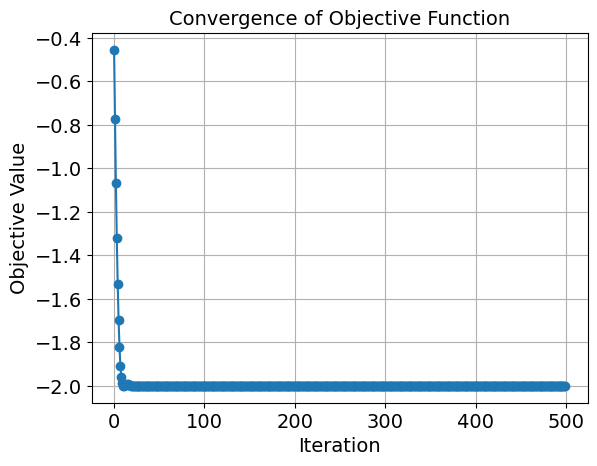

In [26]:
import jax
import jax.numpy as jnp
from jaxopt import GradientDescent
import matplotlib.pyplot as plt

# Define the quadratic function
def objective(x):
    Q = jnp.array([[3.0, 0.5], [0.5, 1.0]])
    b = jnp.array([1.0, 2.0])
    return 0.5 * jnp.dot(x, jnp.dot(Q, x)) - jnp.dot(b, x)

# Initialize optimizer
gd = GradientDescent(fun=objective, stepsize=0.1)

# Define a scan function to iterate with `jax.lax.scan`
def scan_fn(carry, _):
    x, state = carry
    x, state = gd.update(x, state)
    obj_value = objective(x)
    return (x, state), obj_value

# Initial point and state
init_x = jnp.array([0.0, 0.0])
init_state = gd.init_state(init_x)

# Run the optimization and collect objective values using `scan`
_, objective_values = jax.lax.scan(scan_fn, (init_x, init_state), None, length=gd.maxiter)

# Plot the convergence
objective_values = jax.device_get(objective_values)  # Move from device to host
plt.plot(objective_values, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Objective Value")
plt.title("Convergence of Objective Function")
plt.grid(True)
plt.show()
